# OPS!
Now you have to considere wich years will constitude your testset. Tree will serve nicely: 2015, 2016, 2017. But if you have the time it would be nice to also estimate with the full set so you can test on 2018 when it come out.

2017 came out around mid 2018. Thus for any pratical use the framework need to be evaluated 2-3 three years into the furture.

In [19]:
import numpy as np
import scipy as sp
import scipy.stats as sts
import pandas as pd
import geopandas as gpd

import pymc3 as pm

import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import time

np.random.seed(24) # 42

# Do the data:

In [20]:
# get data:

def get_data():

    pkl_file = open('full_df.pkl', 'rb')

    df = pickle.load(pkl_file)

    pkl_file.close()
    
    y_north_limit = 50
    y_south_limit = - 10
    x_east_limit = 100
    x_west_limit  = -20
    
    df_sub = df[(df['ycoord'] > y_south_limit)&(df['ycoord'] < y_north_limit)&(df['xcoord']<x_east_limit)&(df['xcoord']>x_west_limit)]
    
    years = np.sort(df['year'].unique())
    
    data = []
    
    for i, j in enumerate(years):
        
        # Data from Prio and UCDP
        df_sub_year = df_sub[df_sub['year']==j]
        X = np.array([df_sub_year['xcoord'], df_sub_year['ycoord']])
        
#         # for spares estimation - better do this out of loop.
#         sub1 = df_sub_year[df_sub_year['best']>0]
#         Xu = np.array([sub1['xcoord'], sub1['ycoord']]).T
        
        # Data from spatial estimation
        file_name = 'spatial_est_{}.pkl'.format(j)
    
        pkl_file = open(file_name, 'rb')

        estimates = pickle.load(pkl_file)

        pkl_file.close()
        
        year_array = np.zeros(X.shape[1]) + j
        
        data.append(np.dstack([estimates['mu'],estimates['var'],X[0],X[1],year_array])[0,:,:]) # to get rid of a spare dim...

    concat_data = np.concatenate(data)
    
    df_new = pd.DataFrame(concat_data, columns= ['mu','var','xcoord','ycoord','year'])        
    df_full = df_sub.merge(df_new, on = ['xcoord','ycoord','year'], how = 'outer')
    
    return(df_full)

df = get_data()
test_df = df[df['year']>=2015].sort_values(['gid','year'])
train_df =  df[df['year']<2015].sort_values(['gid','year'])

def get_X_new(step_size = 0.25):
    step = step_size
    min_year = df['year'].min()
    max_year = df['year'].max()

    X_new = np.arange(min_year,max_year + step, step)[:,None]
    
    return(X_new)


# X and y and index
X = np.array(train_df['year'])[:,None]
y = np.array(train_df['mu'])
index = np.array(train_df['gid'])

# subset for map est:
# gid_list = np.random.choice(df[df['mu']>1]['gid'].unique(),100) # random non zeores. Fungere godt med 100..
# gid_list = np.random.choice(df[df['mu']>3]['gid'].unique(),100) # random non zeores. Fungere godt med 100..

# ----------------------------------------
gid_list = []

for i in df['gid'].unique():
        
    timeline  = df[df['gid'] == i]
    if np.count_nonzero(timeline['log_best']) >= 2:
        gid_list.append(i)
        
gid_list = np.random.choice(gid_list, 100) # number of samples for hyper parameter estimates. ++++++++++++++++++++++++++++++++
#-----------------------------------------

# train_df_sub = train_df.sample(100)
train_df_sub = train_df[train_df['gid'].isin(gid_list)].sort_values(['gid','year'])

X1 = np.array(train_df_sub['year'])[:,None]
y1 = np.array(train_df_sub['mu'])
index1 = np.array(train_df_sub['gid'])

# New X.
X_new = get_X_new()

# Visualisation of the data

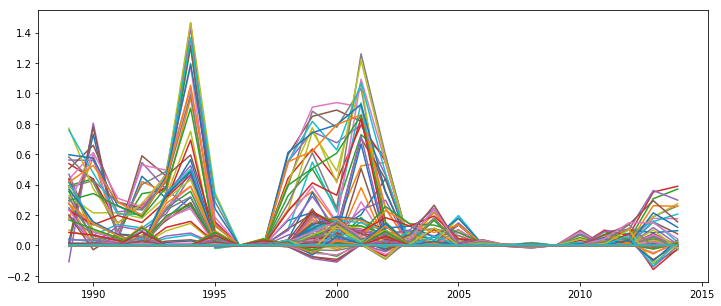

In [21]:
# Random:

fig = plt.figure(figsize=(12,5))

for i, j in enumerate(np.unique(index)[0:100]):
    plt.plot(X[index == j], y[index==j])
    
plt.show()



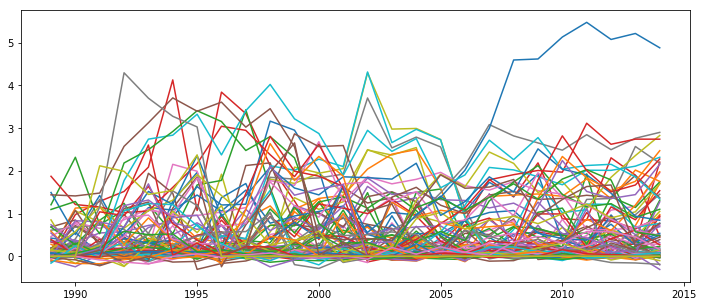

In [22]:
# Obs with 2 or more events doing timeline for estimation of hyper parameters.

fig = plt.figure(figsize=(12,5))

for i, j in enumerate(np.unique(index1)[0:100]):
    plt.plot(X1[index1 == j], y1[index1==j])
    
plt.show()

# Estimation

### Define and illlustrate hyper-priors:

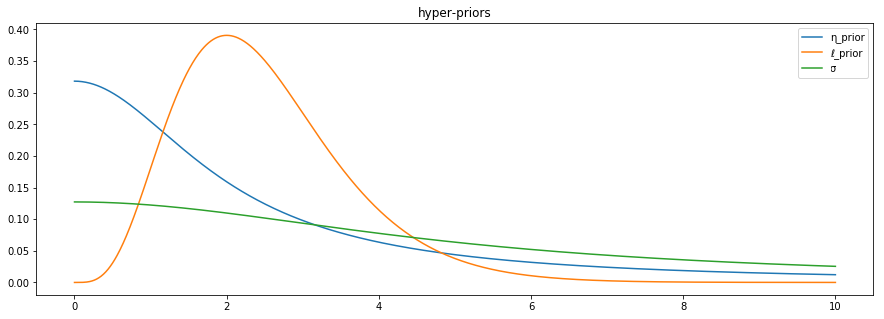

In [23]:
η_beta = 2
ℓ_beta = 2
ℓ_alpha = 5
σ_beta = 5

grid = np.linspace(0,10,1000)
priors = [
    ('η_prior', pm.HalfCauchy.dist(beta=η_beta)),
    ('ℓ_prior', pm.Gamma.dist(alpha=ℓ_alpha , beta=ℓ_beta )),
    ('σ', pm.HalfCauchy.dist(beta=σ_beta))]

plt.figure(figsize= [15,5])
plt.title('hyper-priors')


for i, prior in enumerate(priors):
    plt.plot(grid, np.exp(prior[1].logp(grid).eval()), label = prior[0])

plt.legend()
plt.show()

### The model
So you need to find uot if you should get map from only a subset of X. Like all with more then two years of bieng near a conflcit.
you can also tyr the sparse implimentation.

# Get map est and sample est:
## One component 

In [24]:
# step0

time0 = time.time()

with pm.Model() as model:
    
    # trend
    ℓ = pm.Gamma("ℓ", alpha=ℓ_alpha , beta=ℓ_beta, shape = 1)
    η = pm.HalfCauchy("η", beta=η_beta, shape = 1)
    
    # noise model
    σ = pm.HalfCauchy("σ", beta=σ_beta, shape = 1)
    
    # Cov func.
    cov = η **2 * pm.gp.cov.ExpQuad(1, ℓ)
    
    # GP
    gp = pm.gp.Marginal(cov_func=cov)

    
    # sample: 
    for i, j in enumerate(np.unique(index1)):
        
#         mean = pm.gp.mean.Constant(np.mean(y[index == j]))
                
        y_ = gp.marginal_likelihood("y" + str(i) + "_", X=X1[index1 == j], y=y1[index1 == j], noise= σ)
        

/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [25]:
time1 = time.time()

with model:
    trace = pm.sample()
    
time1 = time.time()
stepallt = (time1 - time0)/60
print('time total: {}min'.format(stepallt))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, η, ℓ]
Sampling 4 chains: 100%|██████████| 4000/4000 [38:51<00:00,  1.59draws/s]
The acceptance probab

time total: 44.203281160195665min


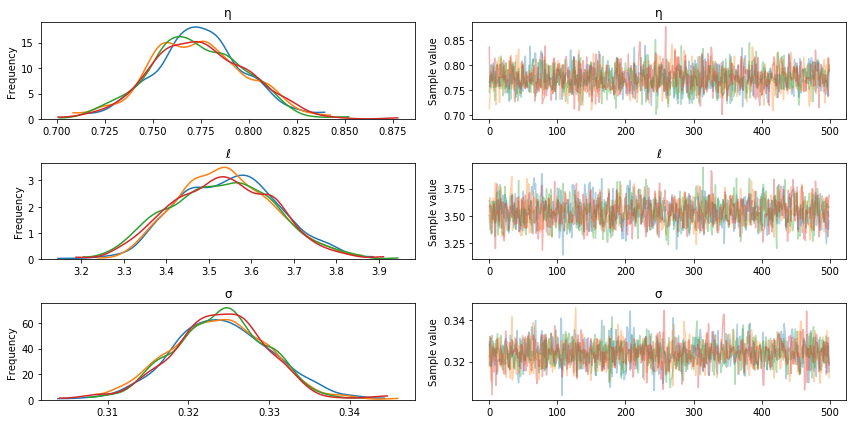

In [26]:
pm.traceplot(trace, varnames=['η', 'ℓ', 'σ'])
plt.show()

In [27]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
ℓ__0,3.536661,0.118202,0.003075,3.320114,3.773437,1543.329140,1.000456
η__0,0.773707,0.024246,0.000610,0.726351,0.820273,1745.814644,1.000064
σ__0,0.323930,0.005947,0.000149,0.312455,0.335104,1832.323315,0.999625


In [28]:
mp = {'ℓ' : np.array([pm.summary(trace)['mean'].iloc[0]]),  
      'η': np.array([pm.summary(trace)['mean'].iloc[1]]), 
      'σ' : np.array([pm.summary(trace)['mean'].iloc[2]])}

In [29]:
mp

{'η': array([0.77370715]), 'σ': array([0.32393014]), 'ℓ': array([3.53666056])}

In [30]:
time2 = time.time()
step0t = (time1 - time0)/60
step1t = (time2 - time1)/60

stepallt = (time2 - time0)/60

print('step 0: {}min \n step 1: {} \n time total: {}min'.format(step0t, step1t, stepallt))

step 0: 44.203281160195665min 
 step 1: 0.08484203815460205 
 time total: 44.28812319835027min


# Prediction
## Obs used to estimate hyper parameters.

In [31]:
time_0 = time.time()

mu_list = []
var_list = []

for i, j in enumerate(np.unique(index1)):
    mu, var = gp.predict(X_new, point=mp, given = {'gp' : gp, 'X' : X1[index1 == j], 'y' : y1[index1 == j], 'noise' : σ }, diag=True)
    
    mu_list.append(mu)
    var_list.append(var)
    
    print('{}/{}'.format(i,np.unique(index1).shape[0]), end = '-')
    
    
    
time_1 = time.time()

time_step1 = (time_1 - time_0)/60

print('total {} min'.format(time_step1))

/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


0/99-1/99-2/99-3/99-4/99-5/99-6/99-7/99-8/99-9/99-10/99-11/99-12/99-13/99-14/99-15/99-16/99-17/99-18/99-19/99-20/99-21/99-22/99-23/99-24/99-25/99-26/99-27/99-28/99-29/99-30/99-31/99-32/99-33/99-34/99-35/99-36/99-37/99-38/99-39/99-40/99-41/99-42/99-43/99-44/99-45/99-46/99-47/99-48/99-49/99-50/99-51/99-52/99-53/99-54/99-55/99-56/99-57/99-58/99-59/99-60/99-61/99-62/99-63/99-64/99-65/99-66/99-67/99-68/99-69/99-70/99-71/99-72/99-73/99-74/99-75/99-76/99-77/99-78/99-79/99-80/99-81/99-82/99-83/99-84/99-85/99-86/99-87/99-88/99-89/99-90/99-91/99-92/99-93/99-94/99-95/99-96/99-97/99-98/99-total 9.574737584590912 min


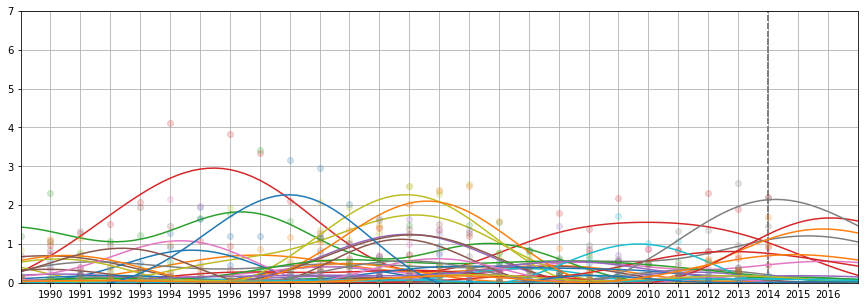

In [33]:
fig = plt.figure(figsize=(15,5))

start = 0
end = 100

for i, j in enumerate(np.unique(index1)[start:end]):
    
    i = i + start
    
    color = 'C' + str(i)[-1] # reiterates after 9
    
    plt.plot(X_new, mu_list[i], color = color)
    plt.plot(X1[index1 == j], y1[index1 == j], 'o' , ms=6, alpha=0.2, color = color)
    plt.vlines(X1.max(),0,y1.max()*2, linestyles='dashed', color = 'gray', label='Last observed year: ' + str(X1.max()))



plt.ylim(0,7)
plt.xlim(X_new.min(),X_new.max())

plt.xticks(np.arange(1990,2017,1))
plt.grid()

plt.show()

## Prediction new timelines (test):

In [69]:
# train_df_sub = train_df.sample(100)
new_gid_list = df['gid'].sample(100)

train_df_sub_sub = train_df[train_df['gid'].isin(new_gid_list)]

X2 = np.array(train_df_sub_sub['year'])[:,None]
y2 = np.array(train_df_sub_sub['mu'])
index2 = np.array(train_df_sub_sub['gid'])

In [70]:
time_0 = time.time()

mu_list = []
var_list = []

for i, j in enumerate(np.unique(index2)):
    
    mu, var = gp.predict(X_new, point=mp, given = {'gp' : gp, 'X' : X2[index2 == j], 'y' : y2[index2 == j], 'noise' : σ },diag=True)
    
    mu_list.append(mu)
    var_list.append(var)
    
    print('{}/{}'.format(i,np.unique(index2).shape[0]), end = '-')
    
    
time_1 = time.time()

time_step1 = (time_1 - time_0)/60

print('total {} min'.format(time_step1))

/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


0/100-1/100-2/100-3/100-4/100-5/100-6/100-7/100-8/100-9/100-10/100-11/100-12/100-13/100-14/100-15/100-16/100-17/100-18/100-19/100-20/100-21/100-22/100-23/100-24/100-25/100-26/100-27/100-28/100-29/100-30/100-31/100-32/100-33/100-34/100-35/100-36/100-37/100-38/100-39/100-40/100-41/100-42/100-43/100-44/100-45/100-46/100-47/100-48/100-49/100-50/100-51/100-52/100-53/100-54/100-55/100-56/100-57/100-58/100-59/100-60/100-61/100-62/100-63/100-64/100-65/100-66/100-67/100-68/100-69/100-70/100-71/100-72/100-73/100-74/100-75/100-76/100-77/100-78/100-79/100-80/100-81/100-82/100-83/100-84/100-85/100-86/100-87/100-88/100-89/100-90/100-91/100-92/100-93/100-94/100-95/100-96/100-97/100-98/100-99/100-total 11.144471883773804 min


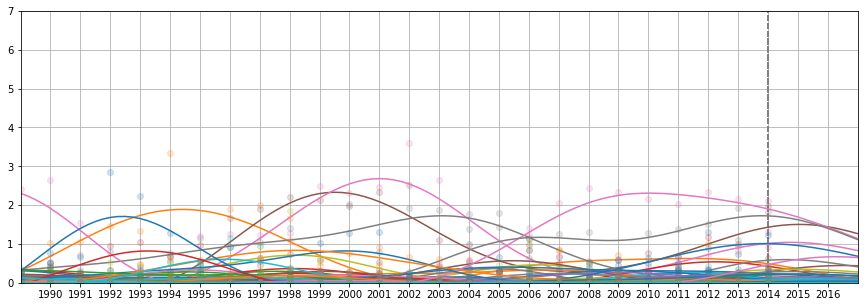

In [71]:
fig = plt.figure(figsize=(15,5))

start = 0
end = 100

for i, j in enumerate(np.unique(index2)[start:end]):
    
    i = i + start
    
    color = 'C' + str(i)[-1] # reiterates after 9
    
    plt.plot(X_new, mu_list[i], color = color)
    plt.plot(X2[index2 == j], y2[index2 == j], 'o' , ms=6, alpha=0.2, color = color)
    plt.vlines(X2.max(),0,y2.max()*2, linestyles='dashed', color = 'gray', label='Last observed year: ' + str(X2.max()))



plt.ylim(0,7)
plt.xlim(X_new.min(),X_new.max())

plt.xticks(np.arange(1990,2017,1))
plt.grid()

plt.show()

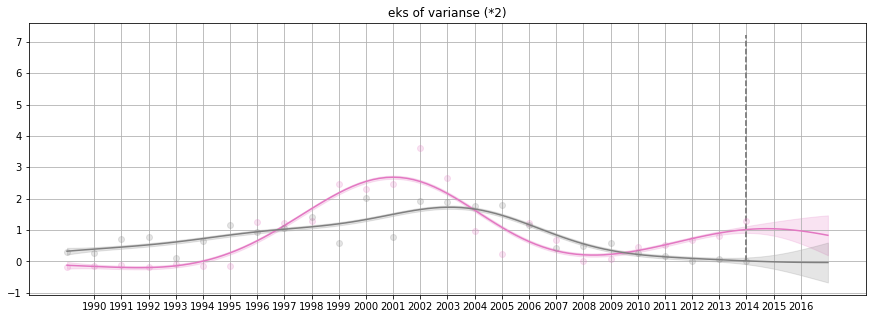

In [96]:
fig = plt.figure(figsize=(15,5))

start = 6
end = 8

for i, j in enumerate(np.unique(index2)[start:end]):
    
    i = i + start
    
    color = 'C' + str(i)[-1] # reiterates after 9
    
    plt.plot(X_new, mu_list[i], color = color)

    
    plt.fill_between(X_new.flatten(), mu_list[i] + (var_list[i] * 2), mu_list[i] - (var_list[i] * 2) , color = color, alpha = 0.2)

    plt.plot(X2[index2 == j], y2[index2 == j], 'o' , ms=6, alpha=0.2, color = color)
    plt.vlines(X2.max(),0,y2.max()*2, linestyles='dashed', color = 'gray', label='Last observed year: ' + str(X2.max()))



# plt.ylim(0,7)
# plt.xlim(X_new.min(),X_new.max())

plt.title('eks of varianse (*2)')
plt.xticks(np.arange(1990,2017,1))
plt.grid()

plt.show()

# Predict all timelines.

In [136]:
df['gid'].unique().shape

(18417,)

In [160]:
time_0 = time.time()

# list for estimations
mu_list = []
var_list = []

 # just to keep 100% track of the timelines.
index_list = []
year_list = []

print('Started..\n')
for i, j in enumerate(np.unique(index)):
    
    mu, var = gp.predict(X_new, point=mp, given = {'gp' : gp, 'X' : X[index == j], 'y' : y[index == j], 'noise' : σ },diag=True)
    
    mu_list.append(mu)
    var_list.append(var)
    index_list.append(j)
    year_list.append(X_new)
    
    if str(i)[-2:] == '00':
        print('{}/{}'.format(i,np.unique(index).shape[0]), end = '-')
        
        # save a backup-dict at every mark (100)
        estimation_dict = {} # use new one at every mark
        estimation_dict['mu'] = np.array(mu_list)
        estimation_dict['var'] = np.array(var_list)
        estimation_dict['index'] = np.array(index_list)
        estimation_dict['year'] = np.array(year_list)
        
        file_path = 'space_time_pkls/space_time_dict{}.pkl'.format(i)
        output = open(file_path, 'wb') # still not working right!!
        pickle.dump(estimation_dict, output)
        output.close()

        
# final dict:

estimation_dict = {} # use new one
estimation_dict['mu'] = np.array(mu_list)
estimation_dict['var'] = np.array(var_list)
estimation_dict['index'] = np.array(index_list)
estimation_dict['year'] = np.array(year_list)
        
file_path = 'space_time_pkls/space_time_dict{}.pkl'.format(i)
output = open(file_path, 'wb') # still not working right!!
pickle.dump(estimation_dict, output)
output.close()
    
time_1 = time.time()

time_step1 = (time_1 - time_0)/60

print('total {} min'.format(time_step1))

Started..



/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


100/18417-total 11.137957306702932 min


# Test the pickle:

In [167]:
pkl_file = open('space_time_pkls/space_time_dict18417.pkl', 'rb')

pickle_test_space_time = pickle.load(pkl_file)

pkl_file.close()

In [168]:
pickle_test_space_time.keys()

dict_keys(['mu', 'var', 'index', 'year'])

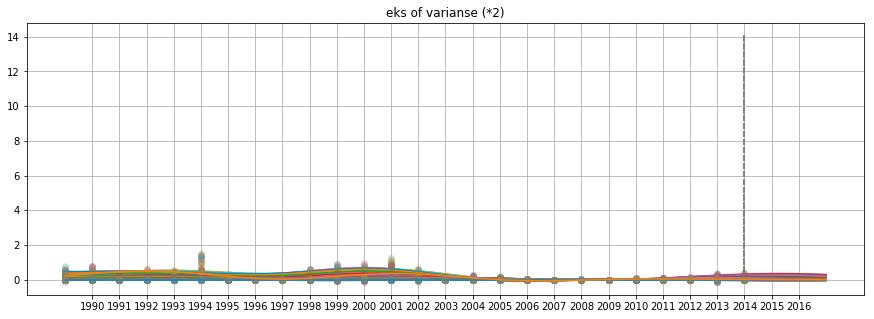

In [177]:
fig = plt.figure(figsize=(15,5))

# random test visual:
start = 5102
end = 5202


for i, j in enumerate(np.unique(pickle_test_space_time['index'])[start:end]):
    
    i = i + start
    
    color = 'C' + str(i)[-1] # reiterates after 9
    
    plt.plot(pickle_test_space_time['year'][i], pickle_test_space_time['mu'][i], color = color)


    plt.plot(X[index == j], y[index == j], 'o' , ms=6, alpha=0.2, color = color)
    plt.vlines(X.max(),0,y.max()*2, linestyles='dashed', color = 'gray', label='Last observed year: ' + str(X.max()))



# plt.ylim(0,7)
# plt.xlim(X_new.min(),X_new.max())

plt.title('eks of varianse (*2)')
plt.xticks(np.arange(1990,2017,1))
plt.grid()

plt.show()